#**Introduction**

This project aims to predict  ride fares based on various trip-related features such as pickup/dropoff locations, time of ride, and passenger count. Multiple machine learning (ML) models are implemented, their performances are compared, and the best-performing model is selected.

#**Step 1: Import Required Libraries**

In [ ]:
import pandas as pd
import numpy as np

# **Step 2: Data Loading**

💡 In this step, we load the Uber fare dataset and check its structure, including missing values, column types, and basic statistics.

In [ ]:
df = pd.read_csv('/content/uber.csv')

In [ ]:
df.head(3)

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         200000 non-null  int64  
 1   key                200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


In [ ]:
df.describe()

,Unnamed: 0,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,2.000000e+05,200000.000000,200000.000000,200000.000000,199999.000000,199999.000000,200000.000000
mean,2.771250e+07,11.359955,-72.527638,39.935885,-72.525292,39.923890,1.684535
std,1.601382e+07,9.901776,11.437787,7.720539,13.117408,6.794829,1.385997
min,1.000000e+00,-52.000000,-1340.648410,-74.015515,-3356.666300,-881.985513,0.000000
25%,1.382535e+07,6.000000,-73.992065,40.734796,-73.991407,40.733823,1.000000
50%,2.774550e+07,8.500000,-73.981823,40.752592,-73.980093,40.753042,1.000000
75%,4.155530e+07,12.500000,-73.967154,40.767158,-73.963658,40.768001,2.000000
max,5.542357e+07,499.000000,57.418457,1644.421482,1153.572603,872.697628,208.000000


In [ ]:
df.shape

(200000, 9)

In [ ]:
df.isnull().sum()

,0
Unnamed: 0,0
key,0
fare_amount,0
pickup_datetime,0
pickup_longitude,0
pickup_latitude,0
dropoff_longitude,1
dropoff_latitude,1
passenger_count,0


In [ ]:
df.duplicated().sum()

np.int64(0)

#**Step 3: Data Preprocessing**

💡 Before proceeding with analysis, we clean the data by removing incorrect values, handling null values, and filtering out unrealistic fare amounts.

In [ ]:
# Drop unnecessary columns
df.drop(columns=["Unnamed: 0", "key"], inplace=True)

In [ ]:
# Convert pickup_datetime to datetime format
df["pickup_datetime"] = pd.to_datetime(df["pickup_datetime"], errors='coerce', utc=True)

In [ ]:
# Drop rows with missing values
df.dropna(inplace=True)

In [ ]:
# Filter out incorrect fare values (negative and unrealistically high fares)
df = df[(df["fare_amount"] > 0) & (df["fare_amount"] < 500)]

In [ ]:
# NYC Valid Coordinates (Rough Boundaries)
NYC_LAT_RANGE = (40.5, 41.5)
NYC_LONG_RANGE = (-74.5, -72.5)

# Remove out-of-bound coordinates
df = df[
    (df["pickup_latitude"].between(*NYC_LAT_RANGE)) &
    (df["pickup_longitude"].between(*NYC_LONG_RANGE)) &
    (df["dropoff_latitude"].between(*NYC_LAT_RANGE)) &
    (df["dropoff_longitude"].between(*NYC_LONG_RANGE))
]

# Drop duplicate rows
df.drop_duplicates(inplace=True)

print(f"Shape after preprocessing: {df.shape}")

Shape after preprocessing: (195760, 7)


<ipython-input-36-764d04a606ad>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(inplace=True)


#**Step 4: Feature Engineering**

💡 We create new meaningful features from the existing dataset, such as extracting time-based features and adding custom indicators for better model performance.

In [ ]:
# Extract time-based features
df["year"] = df["pickup_datetime"].dt.year
df["month"] = df["pickup_datetime"].dt.month
df["day"] = df["pickup_datetime"].dt.day
df["day_of_week"] = df["pickup_datetime"].dt.dayofweek
df["hour"] = df["pickup_datetime"].dt.hour

# Additional categorical features
df["is_rush_hour"] = df["hour"].apply(lambda x: 1 if (7 <= x <= 9 or 16 <= x <= 19) else 0)
df["is_night"] = df["hour"].apply(lambda x: 1 if (x < 6 or x > 22) else 0)
df["is_weekend"] = df["day_of_week"].apply(lambda x: 1 if x >= 5 else 0)

# Calculate Haversine distance (great-circle distance between points)
from geopy.distance import great_circle

def haversine_distance(lat1, lon1, lat2, lon2):
    return great_circle((lat1, lon1), (lat2, lon2)).km

df["distance_km"] = df.apply(lambda row: haversine_distance(
    row["pickup_latitude"], row["pickup_longitude"], row["dropoff_latitude"], row["dropoff_longitude"]), axis=1)

df = df[df["distance_km"] > 0]  # Removing zero-distance rides

<ipython-input-37-2c2c52f5bc86>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["year"] = df["pickup_datetime"].dt.year
<ipython-input-37-2c2c52f5bc86>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["month"] = df["pickup_datetime"].dt.month


#**Step 5: Data Visualization**

**Fare Amount Distribution**

💡 In this step, we explore the dataset using powerful visualizations to uncover patterns and trends.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

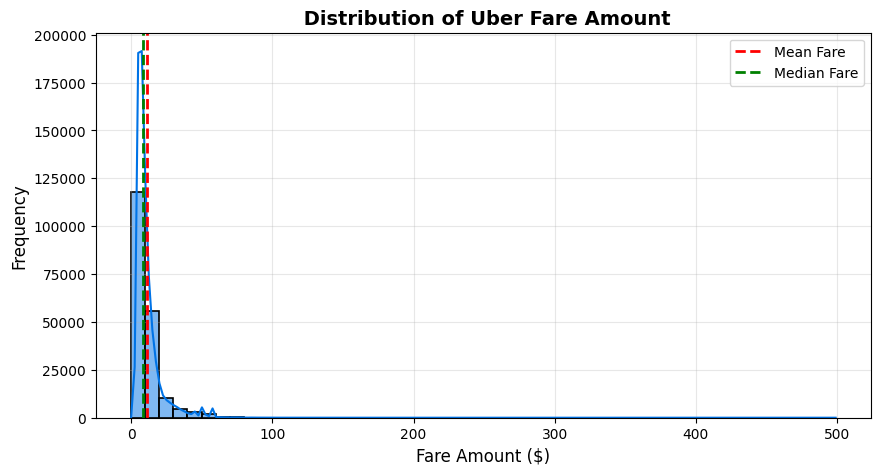

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(df["fare_amount"], bins=50, kde=True, color="#0073e6", edgecolor="black", linewidth=1.2)
plt.axvline(df["fare_amount"].mean(), color="red", linestyle="dashed", linewidth=2, label="Mean Fare")
plt.axvline(df["fare_amount"].median(), color="green", linestyle="dashed", linewidth=2, label="Median Fare")
plt.title(" Distribution of Uber Fare Amount", fontsize=14, fontweight="bold")
plt.xlabel("Fare Amount ($)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.show()

**Pickup Locations Heatmap using Folium**

In [ ]:
import folium
from folium.plugins import HeatMap


# Create a base map
nyc_map = folium.Map(location=[40.75, -74.00], zoom_start=11)

# Add pickup locations as a heatmap
heat_data = list(zip(df['pickup_latitude'], df['pickup_longitude']))
HeatMap(heat_data[:10000]).add_to(nyc_map)  # Limit to 10k points for speed

# Show the map
nyc_map

**Rush Hour vs Non-Rush Hour Fare**

<ipython-input-41-762d66c0f37a>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="is_rush_hour", y="fare_amount", data=df, palette=["#FF4500", "#32CD32"], width=0.6)


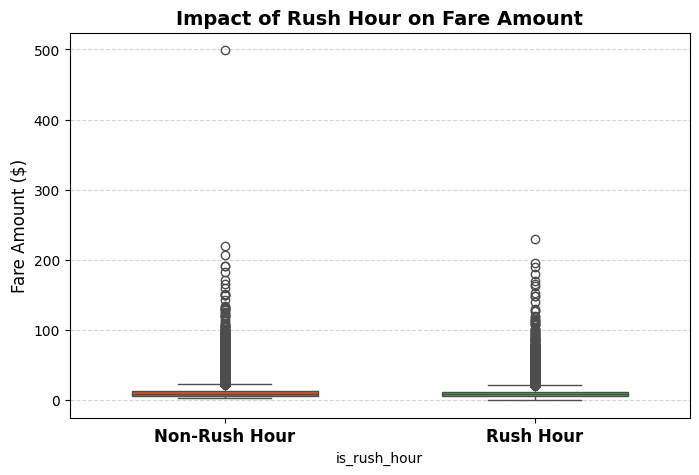

In [ ]:
plt.figure(figsize=(8, 5))
sns.boxplot(x="is_rush_hour", y="fare_amount", data=df, palette=["#FF4500", "#32CD32"], width=0.6)
plt.xticks([0, 1], ["Non-Rush Hour", "Rush Hour"], fontsize=12, fontweight="bold")
plt.ylabel("Fare Amount ($)", fontsize=12)
plt.title("Impact of Rush Hour on Fare Amount", fontsize=14, fontweight="bold")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()

**Correlation Matrix for Feature Relationships**

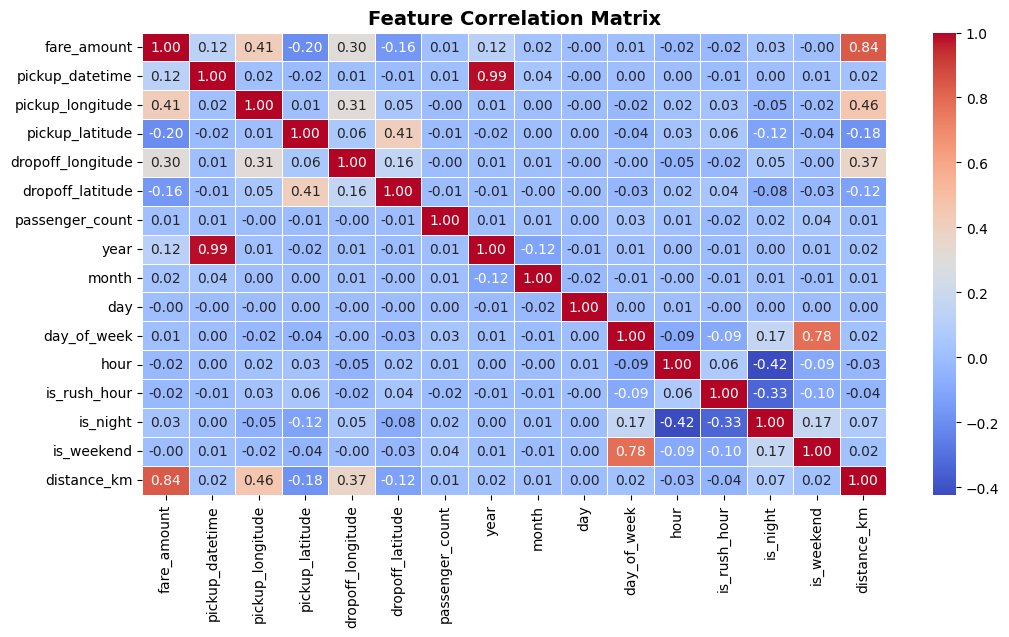

In [ ]:
correlation_matrix = df.corr()
plt.figure(figsize=(12, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Matrix", fontsize=14, fontweight='bold')
plt.show()

#**step 6: Data Splitting and Scaling**

💡 We scale the numerical features and split the dataset into training and testing sets for model training

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# Selecting features and target
features = ["pickup_longitude", "pickup_latitude", "dropoff_longitude", "dropoff_latitude",
            "passenger_count", "year", "month", "day", "day_of_week", "hour",
            "is_rush_hour", "is_night", "is_weekend", "distance_km"]

X = df[features]
y = df["fare_amount"]

# Splitting dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#**Step 7: Train and Evaluate Models**


💡 We are train two machine learning models and compare their initial performance

**Linear Regression**

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)
print(f"Linear Regression - MAE: {mae_lr:.2f}, R²: {r2_lr:.2f}")

Linear Regression - MAE: 2.30, R²: 0.76


 **XGBoost**

In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score
import xgboost as xgb

xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)
print(f"XGBoost - MAE: {mae_xgb:.2f}, R²: {r2_xgb:.2f}")

XGBoost - MAE: 1.73, R²: 0.86


**RandomForestRegression**

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print(f"Random Forest - MAE: {mae_rf:.2f}, R²: {r2_rf:.2f}")

Random Forest - MAE: 1.77, R²: 0.85
